# Image Augmentation

https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

[MNIST Augmentation](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [1]:
import keras
from keras.datasets import cifar10
import numpy as np

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [2]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [3]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
#    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
#    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

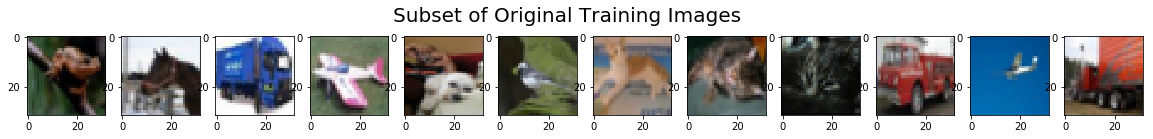

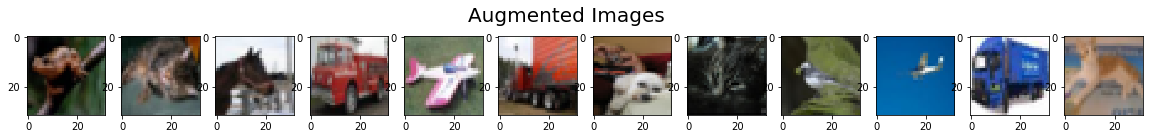

In [8]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from fnn_helper import PlotLosses

In [15]:
def get_model_2():
    p=0.25
    model = Sequential()
    model.add(Convolution2D(filters=6, strides=1, kernel_size=6, padding='same',input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(p))
    model.add(Convolution2D(filters=12, strides=2, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(p))
    model.add(Convolution2D(filters=24, strides=2, kernel_size=4, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(p))
    model.add(Flatten())
    model.add(Dense(200))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(p))
    model.add(Dense(10, activation='softmax'))
    return model
model = get_model_2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 6)         654       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 6)         24        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 12)        1812      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 12)        48        
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 12)        0         
__________

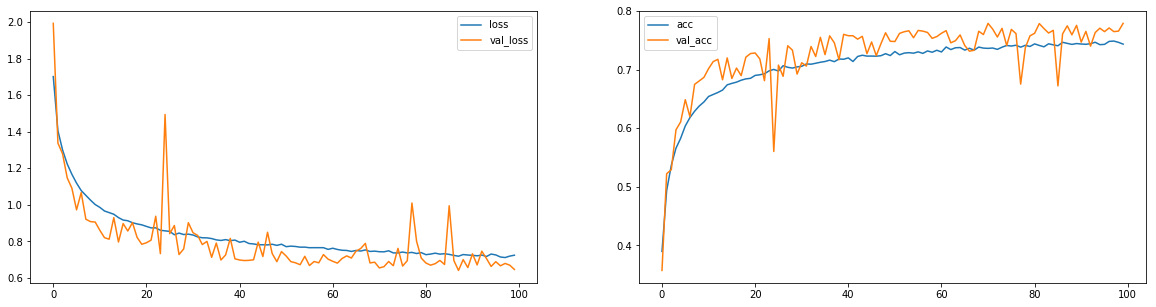

1406/1406 [==============================] - 18s - loss: 0.7238 - acc: 0.7431 - val_loss: 0.6455 - val_acc: 0.7788


In [20]:
model_2 = get_model_2()
adam = optimizers.Adam(lr=0.001)
model_2.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_valid, y_val_categorical=y_valid)


model_2.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer, plot_losses],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

In [21]:
# Cargo los valores del modelo
model_2.load_weights('aug_model.weights.best.hdf5')
score = model_2.evaluate(x_test, y_test, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.684117323685
accuracy:  0.7618
